# Part 1 - Exploratory Data Analysis

In [1]:
#import libraries

library(MASS)
library(car)
library(ROCR)

Loading required package: carData
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



Import the glass data set and change column names 


In [2]:
tbl <- read.csv("glass.data.csv", header = F, 
                col.names = c("ID", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Glass_type"))



In [3]:
# Check for NA, despite dataset description states no NA
sum(is.na(tbl))

[1] 0

The glass types from 1 to 4 are needed

From data set description: 0 values when glass type = 4

In [4]:
tbl <- subset(tbl, Glass_type == "1" | Glass_type == "2" | 
                Glass_type == "3", select = RI:Glass_type)


In order to classify between between window or non-window fragment, float glass gets value of 1 and non-float one keeps value of 2


In [5]:
tbl$Glass_type[tbl$Glass_type == "1" | tbl$Glass_type == "3"] <- 1


Scatter plot matrix is used to assess the distribution of glass components visually


Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of th

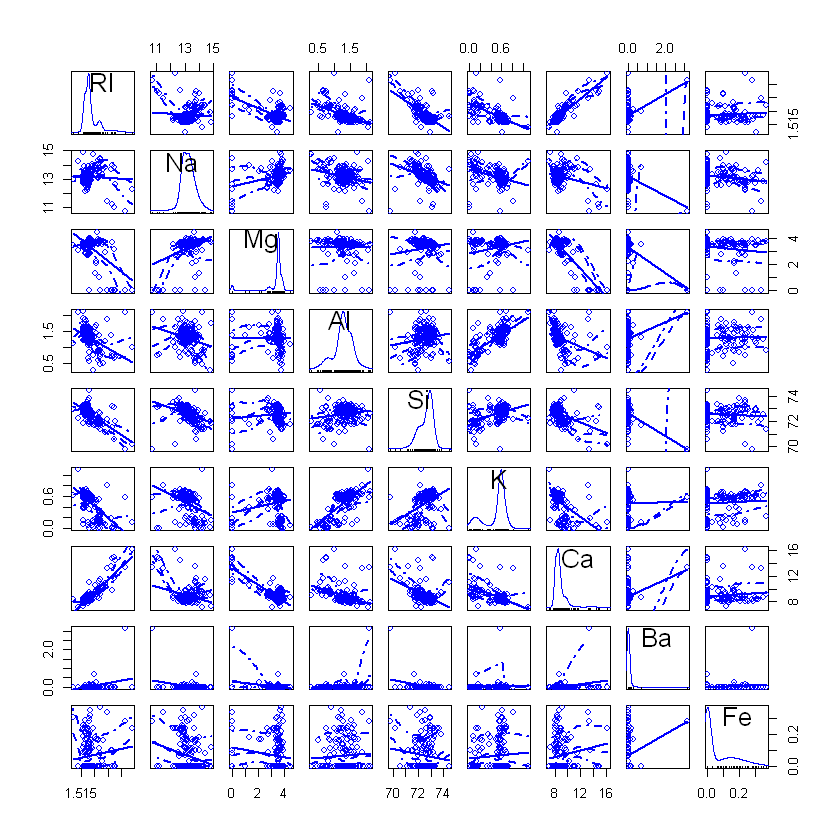

In [6]:
scatterplotMatrix(tbl[-10])


Check homogeneity of variance with Box´s M-test. P-value of 0 indicates that there is no homogeneity of variance

In [7]:
source("https://imada.sdu.dk/~chdj/ST514/F20/BoxM.r")

BoxM(tbl[1:9], tbl$Glass_type, Ftest = F)


M,Chi,df,p
470.847,443.185,45,0


### Normality Check and Data Transformation

For a robust analysis, I check if the dataset is normally distributed by plotting the Mahalanobis distance vs. the quantiles of χ2 (chi-squared) distribution and calculate the correlation between the Mahalanobis distance and the quantiles. 


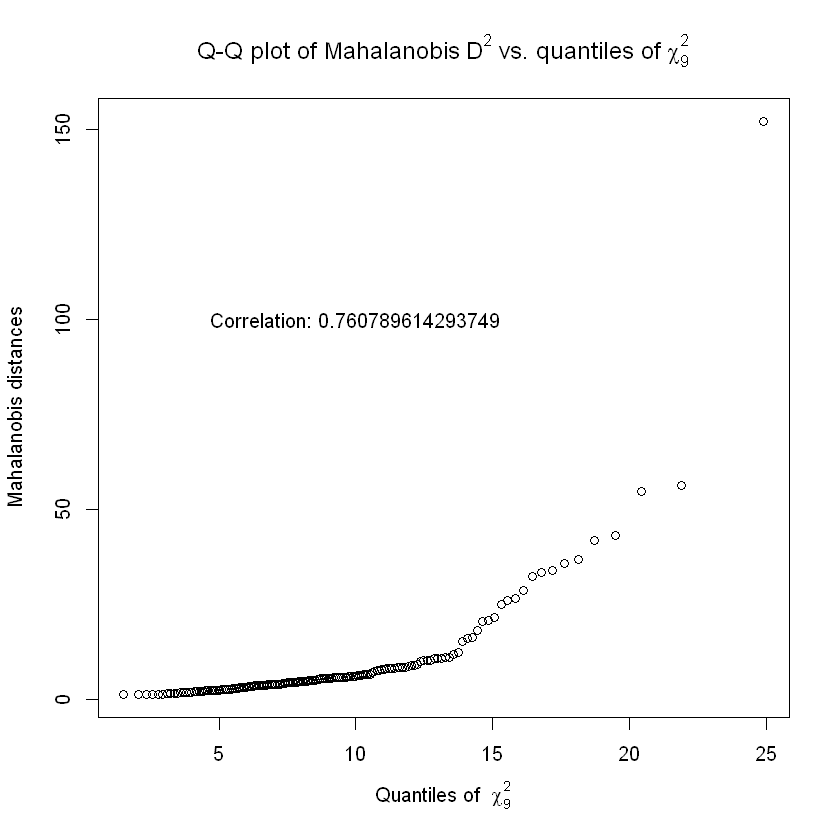

In [21]:
x <- tbl[-10]
xbar <- colMeans(x)
S <- cov(x)
n <- nrow(x)
p <- ncol(x)
D2 <- mahalanobis(x, xbar, S)

test <- qqplot(qchisq(ppoints(n, a = 0.5), df = p), D2,
               ylab = "Mahalanobis distances",
               xlab = bquote("Quantiles of " ~ chi[.(p)]^2),
               main = bquote("Q-Q plot of Mahalanobis" * ~ D^2 * 
                               " vs. quantiles of" * ~ chi[.(p)]^2))

text(10, 100, labels = paste("Correlation:", cor(test$x, test$y)))


The correlation is equal to 0.7607896. By comparing it to the critical value of 0.9913 for n = 150 (our data is 163 instances), it is lower and therefore the dataset does not appear normally distributed


After the transformation of the data and repeting the same step, the correlation value is equal to 0.8760326, that is higher than the non-transformed data (0.7607896), but still lower than the critical value of 0.9913. 

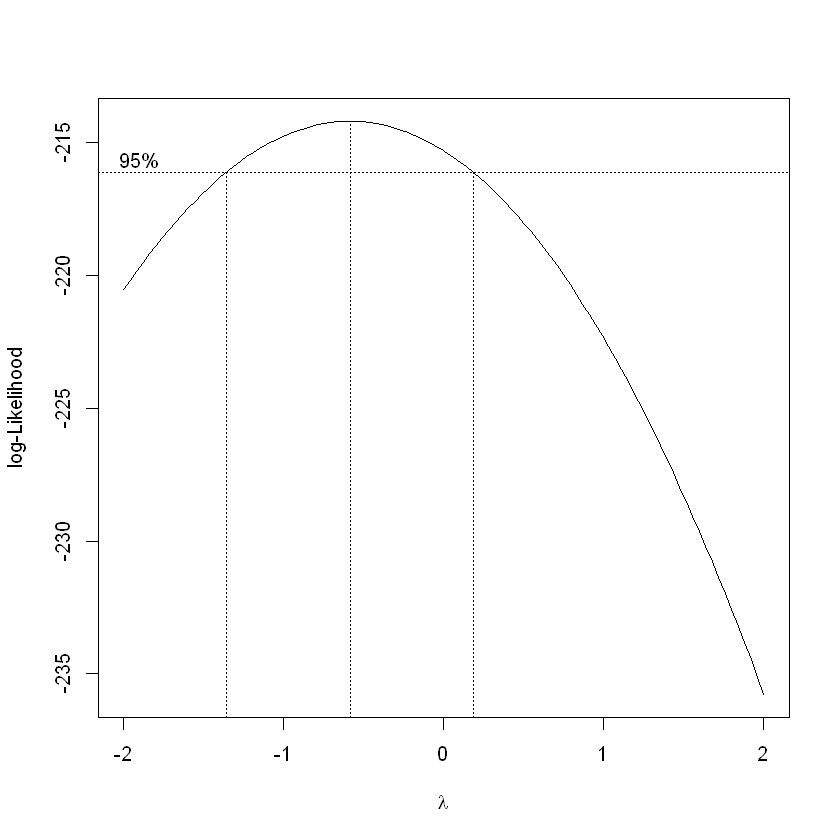

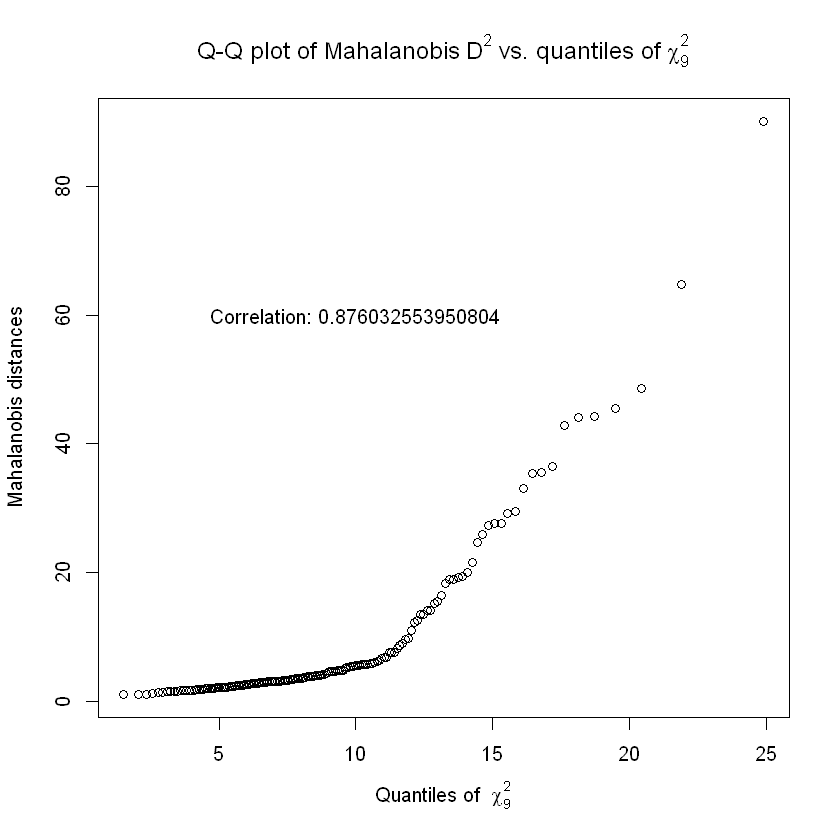

In [12]:
# BoxCox method to transform dataset into a normally distributed one

boxcox(tbl[,10]~tbl[,1] + tbl[,2] + tbl[,3] + tbl[,4] + tbl[,5] + tbl[,6] + tbl[,7] + tbl[,8] + tbl[,9]) #we get lambda from plot generated by this cmd
lambda <- seq(-.5,.1,.01) 
n <- length(lambda)
for (i in 1:n){
  for (j in 1:n){
    if (lambda[i] != 0){
      xt <- (tbl^lambda[i]-1)/lambda[i]
    }
    else{
      xt <- log(tbl+1)
    }
  }
}
xt$Glass_type[xt$Glass_type == "0"] <- 1
xt$Glass_type[xt$Glass_type != "1"] <- 2

x <- xt[-10]
xbar <- colMeans(x)
S <- cov(x)
n <- nrow(x)
p <- ncol(x)
D2 <- mahalanobis(x, xbar, S)
test <- qqplot(qchisq(ppoints(n, a = 0.5), df = p), D2,
               ylab = "Mahalanobis distances",
               xlab = bquote("Quantiles of " ~ chi[.(p)]^2),
               main = bquote("Q-Q plot of Mahalanobis" * ~ D^2 * 
                               " vs. quantiles of" * ~ chi[.(p)]^2))
text(10, 60, labels = paste("Correlation:", cor(test$x, test$y)))


#### If we compare the 2 plots, the transformed data looks more normally distributed than the non-transformed data. 

#### Moreover, the presence outliers causes skewness in the distribution. 

#### I proceed with the analysis using the transformed dataset

### PRINCIPAL COMPONENT ANALYSIS (PCA)

According to the literature, the refractive index can capture minor variations of glass types but it is not sufficient to classify well against glass fragments due to overlapping properties and impurities within raw materials.  

Thus, the variance is important to understand the information contained in the dataset. PCA reveals relationships that would not stand out ordinarily because the abstracted dimensions offer insights about what characterizes the data most and which variables contain more information. For a deeper understanding of PCA, look at Johnson and Whichern, pp. 431, 2014.

In this case, the PCA method uses eigenvalue decomposition of a 9x9 covariance matrix. The linear combination of the variables that explains the maximum variance would be the first principal component. 

PCA requires:

- the inverse of the covariance matrix exists
- the variances of those linear combinations would be as large as possible
- there must be an inequality of variance among the components
- the principal components must be uncorrelated linear combinations.

In relation to the first assumption, I adopt the sample covariance matrix to estimate the population covariance matrix in accordance with the Law of large numbers, since the dataset is large.

In [13]:
# covariance matrix
S <- cov(tbl) 
E <- eigen(S)  


In [14]:
#Diagonal matrix with inverse of eigenvalues
Lambda <- diag(E$values^-1)	

In [15]:
#Eigenvectors
Gamma <- E$vectors 


In [16]:
#Compute the inverse
S_Inverse <- Gamma%*%Lambda%*%t(Gamma) 


In [17]:
# Check inverse covariance matrix exists
round(S_Inverse%*%S,5)


RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Glass_type
1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,1


In [18]:
# PCA on transformed data using BoxCox transformation
transformed_data <- xt[,1:9]
pca <- prcomp(transformed_data, scale=T)
summary(pca)
pca


Importance of components:
                          PC1    PC2    PC3     PC4   PC5     PC6     PC7
Standard deviation     1.8678 1.2867 1.1482 0.91455 0.895 0.68168 0.55377
Proportion of Variance 0.3876 0.1840 0.1465 0.09293 0.089 0.05163 0.03407
Cumulative Proportion  0.3876 0.5716 0.7181 0.81103 0.900 0.95166 0.98573
                          PC8     PC9
Standard deviation     0.2767 0.22776
Proportion of Variance 0.0085 0.00576
Cumulative Proportion  0.9942 1.00000

Standard deviations (1, .., p=9):
[1] 1.8678346 1.2866963 1.1482336 0.9145517 0.8949832 0.6816799 0.5537709
[8] 0.2766659 0.2277562

Rotation (n x k) = (9 x 9):
           PC1          PC2         PC3         PC4         PC5         PC6
RI -0.50279352  0.009339504 -0.14292008  0.01723800 -0.17774334  0.22875823
Na  0.05848990  0.659160997 -0.29399375 -0.02685897  0.03777625 -0.41956590
Mg  0.40976439  0.319736354 -0.20224885 -0.03013691  0.11837866  0.36132824
Al  0.29983920 -0.432455415 -0.13476513  0.16333315 -0.44684954 -0.56753352
Si  0.31115098 -0.236035815  0.52412300 -0.10496146  0.42770171  0.04736805
K   0.34789147 -0.203337198 -0.36402062 -0.06031007 -0.38174397  0.53034123
Ca -0.50894773 -0.139524531  0.05869287 -0.04371418 -0.10532668  0.09316192
Ba -0.07010123 -0.269099550 -0.46988267  0.62302072  0.55323645  0.01030321
Fe -0.06466708 -0.295347163 -0.45013862 -0.75277855  0.32782731 -0.16337345
           PC7          PC8         PC9
RI -0.11011969  0.434729121  0.66434131

Hence, the PCA analysis on the transformed dataset of 214 observations indicates a considerable drop of variances after three components (screeplot). 

The assumption of large variances and the inequality among components is satisfied. 

The first component accounts for 38,76 %, the second component 18.4 %, the third component 14.65 % and the fourth component 9.29 % of the total variance. 

#### The first four components account for 81.11 % of the total variance in original attributes, while the first two components explain 57.16 % of it.

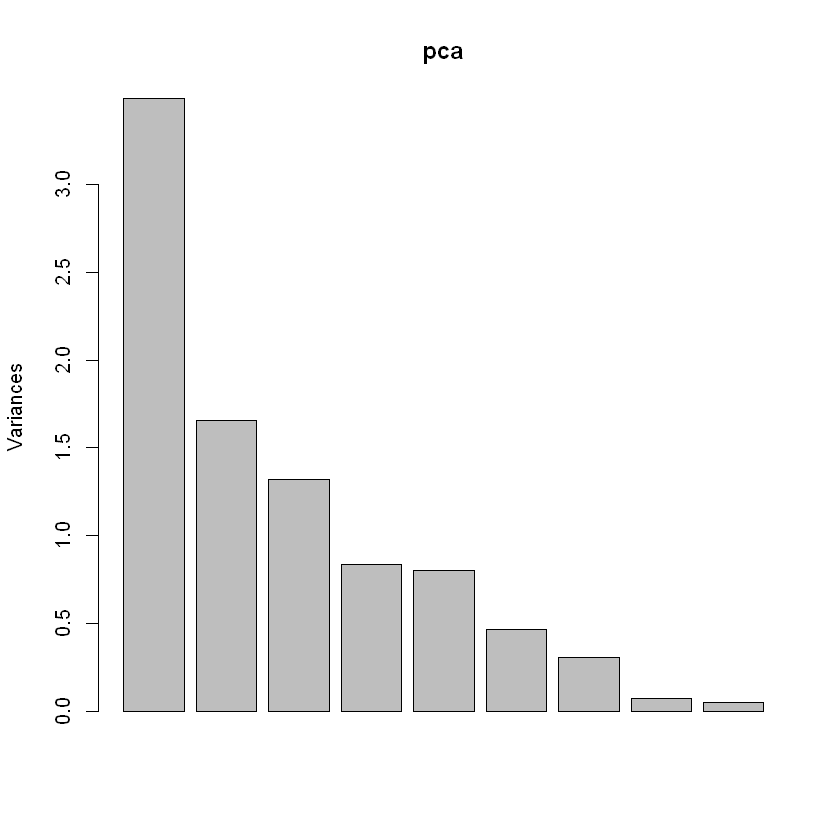

In [19]:
#Barplot of variances explained 

screeplot(pca)

Biplot of first two principal components 

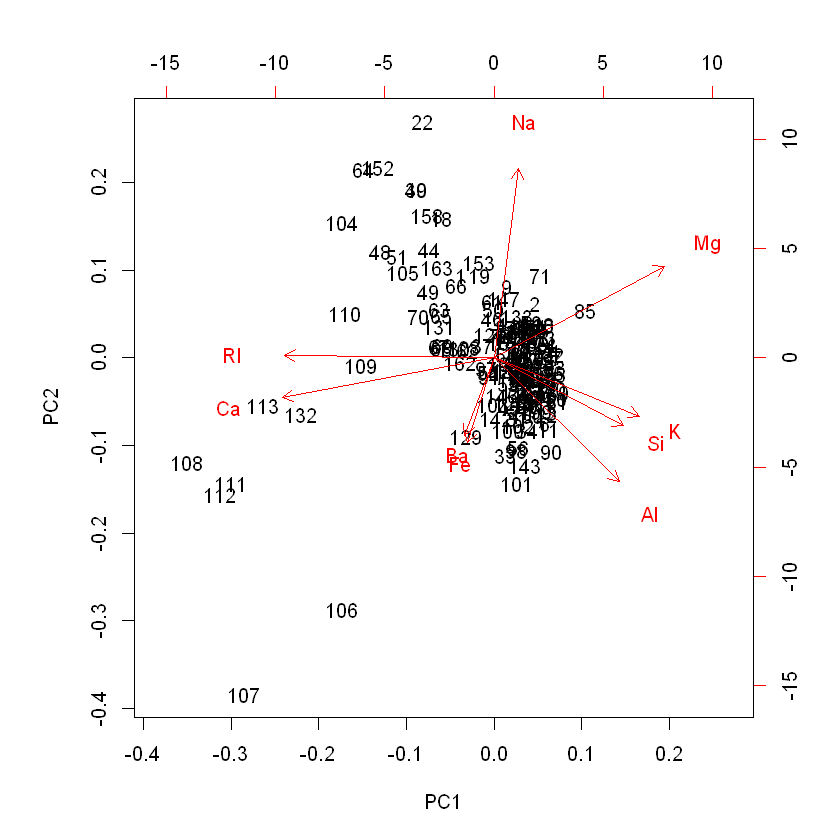

In [20]:
biplot(pca)

The principal components are uncorrelated by looking at their directions are orthogonal. 

In the biplot, it can be observed that Mg, Al, Si, and K contribute to the principal component 1 (PC1). Instead, Na and RI contribute to the principal component 2 (PC2).